In [2]:
import numpy as np
import pandas as pd

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from sklearn import preprocessing, model_selection, linear_model
from sklearn import ensemble, metrics

dirname = '/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/'
all_df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
all_df = all_df.drop_duplicates().sort_index()
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}



In [13]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

births = df[df['Birth frame','Meta']]
births[('Relative basal area','Measurement')] = \
    births['Basal area','Measurement'] / births['Mean adjac Basal area','Measurement']

births

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_83567/3640751628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births[('Relative basal area','Measurement')] = \


Name          Nuclear volume Nuclear solidity Nuclear bbox top  \
Metadata         Measurement      Measurement      Measurement   
Frame TrackID                                                    
1     3             116.6250         0.848954             41.0   
      4             101.6875         0.813500             42.0   
      29            151.6250         0.854526             49.0   
      30            143.4375         0.811815             41.0   
      39            138.8750         0.915157             44.0   
...                      ...              ...              ...   
12    827            96.8750         0.738799             49.0   
      869           121.8750         0.845620             47.0   
13    823           134.4375         0.831465             48.0   
      844           132.0625         0.916305             44.0   
      1022          101.9375         0.780756             43.0   

Name          Nuclear bbox bottom           Z           Y           X  \
Metadata              Measurement Measurement Measurement Measurement   
Frame TrackID                                                           
1     3                      51.0   45.346731  107.626340   36.175643   
      4                      52.0   46.580824  106.917179   41.199754   
      29                     56.0   51.597279   22.018343   78.469291   
      30                     52.0   46.395643   18.079521   82.449455   
      39                     54.0   47.996850   47.045792   87.840684   
...                           ...         ...         ...         ...   
12    827                    58.0   52.716774   19.161290   12.363387   
      869                    56.0   50.438974   57.029615   42.455897   
13    823                    59.0   52.760112   12.942701   22.346467   
      844                    55.0   48.685282   18.620800   97.751775   
      1022                   51.0   46.083998  109.656652   15.609135   

Name          Nuclear height Cell volume      Z-cyto  ...  \
Metadata         Measurement Measurement Measurement  ...   
Frame TrackID                                         ...   
1     3                -10.0    278.5000   44.794434  ...   
      4                -10.0    294.6250   46.476665  ...   
      29                -7.0    291.5000   51.080189  ...   
      30               -11.0    497.6875   47.175688  ...   
      39               -10.0    345.6875   47.974146  ...   
...                      ...         ...         ...  ...   
12    827               -9.0    330.9375   53.250803  ...   
      869               -9.0    329.2500   49.575740  ...   
13    823              -11.0    365.0000   52.984589  ...   
      844              -11.0    275.6875   48.847654  ...   
      1022              -8.0    271.1250   45.722222  ...   

Name          Mean adjac Cell volume standard at 1 frame prior  \
Metadata                                           Measurement   
Frame TrackID                                                    
1     3                                               0.908434   
      4                                               0.908434   
      29                                              0.916417   
      30                                              0.916417   
      39                                              1.035935   
...                                                        ...   
12    827                                             1.034912   
      869                                              1.03202   
13    823                                             0.907546   
      844                                              0.97493   
      1022                                            0.902094   

Name          Std adjac cyto_shcoeffs_L4M5C at 1 frame prior  \
Metadata                                         Measurement   
Frame TrackID                                                  
1     3                                                  0.0   
      4         

In [81]:
measurements = births.xs('Measurement',level=1,axis=1)
features['name'] = measurements.columns
features =features.set_index('name')
features['Num NA'] = measurements.isna().sum(axis=0)

_df = births.droplevel(level=1,axis=1)[['Basal area','Relative basal area','Cell volume exponential growth rate','Will differentiate']].dropna()
_df = _df.rename(columns={'Basal area':'barea',
                  'Relative basal area':'rel_barea',
                  'Cell volume exponential growth rate':'vol_gr',
                  'Will differentiate':'diff',
                 })

_df = _df.reset_index(drop=True).astype(float)
X = _df.drop(columns='diff')
y = _df['diff']

X = preprocessing.StandardScaler().fit_transform(X)
X = pd.DataFrame(X,columns=['barea','rel_barea','vol_gr'])

In [82]:
import statsmodels.api as sm

X = sm.tools.add_constant(X)

model = sm.Logit(y,X).fit_regularized()
model.summary()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3400411664899625
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   diff   No. Observations:                  276
Model:                          Logit   Df Residuals:                      272
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Jul 2025   Pseudo R-squ.:                  0.5052
Time:                        13:44:42   Log-Likelihood:                -93.851
converged:                       True   LL-Null:                       -189.67
Covariance Type:            nonrobust   LLR p-value:                 2.690e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5826      0.193     -3.011      0.003      -0.962      -0.203
barea         -0.9740      0.315     -3.095      0.002      -1.591      -0.357
rel_barea     -0.2551      0.281     -0.908      0.364      -0.806       0.295
vol_gr        -2.7720      0.340     -8.142      0.000      -3.439      -2.105
==============================================================================
"""

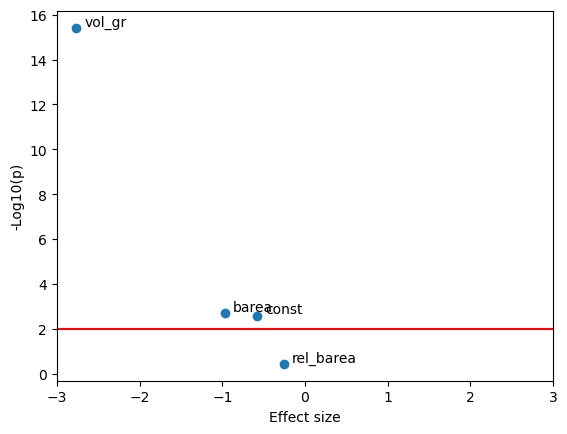

In [106]:
effect_sizes = model.params
log_pvals = -np.log10(model.pvalues)
plt.scatter(effect_sizes,log_pvals)
plt.xlim([-3,3])
plt.hlines(-np.log10(0.01),xmin=-3,xmax=3, color='red')
plt.xlabel('Effect size'); plt.ylabel('-Log10(p)')

for name in effect_sizes.index:
    plt.text(x=effect_sizes[name]+0.1,y=log_pvals[name]+0.1,s=name)

In [104]:
[idx for idx in effect_sizes.index]

['const', 'barea', 'rel_barea', 'vol_gr']

<Axes: xlabel='vol_gr', ylabel='diff'>

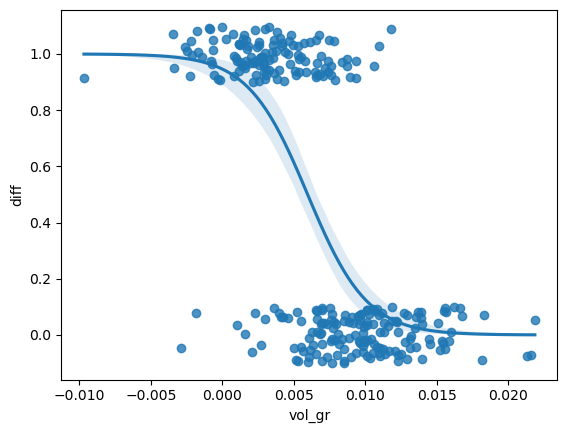

In [114]:
sb.regplot(_df,x='vol_gr',y='diff',logistic=True,y_jitter=0.1)

<Axes: xlabel='barea', ylabel='diff'>

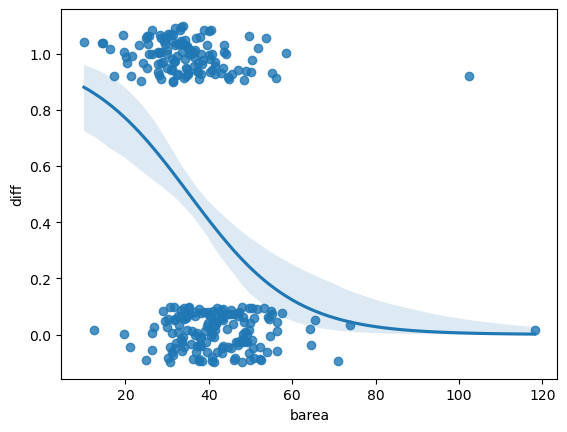

In [113]:
sb.regplot(_df,x='barea',y='diff',logistic=True,y_jitter=0.1)

In [116]:
births[births['Basal area','Measurement'] > 80]

,Name,Nuclear volume,Nuclear solidity,Nuclear bbox top,Nuclear bbox bottom,Z,Y,X,Nuclear height,Cell volume,Z-cyto,...,Mean adjac Cell volume standard at 1 frame prior,Std adjac cyto_shcoeffs_L4M5C at 1 frame prior,Median adjac Apical area smoothed at 1 frame prior,Std adjac cyto_shcoeffs_L1M5C at 1 frame prior,Num neighbor division 1 frame prior,Num neighbor delamination 1 frame prior,Num daughter differentiated,At least one daughter differentiated,Both daughters differentiated,Relative basal area
,Metadata,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,...,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Meta,Meta,Meta,Measurement
Frame,TrackID,,,,,,,,,,,,,,,,,,,,,
2,911,129.9375,0.845466,51.0,60.0,55.427128,7.41366,31.979798,-9.0,831.1875,54.644785,...,0.847685,0.0,13.720052,0.0,0.0,2.0,NaN,NaN,NaN,2.945483
3,482,113.8125,0.798334,44.0,54.0,48.035695,103.98078,76.032949,-10.0,1111.9375,50.151088,...,0.962292,0.0,13.094643,0.0,0.0,0.0,NaN,NaN,NaN,4.186462


<Axes: >

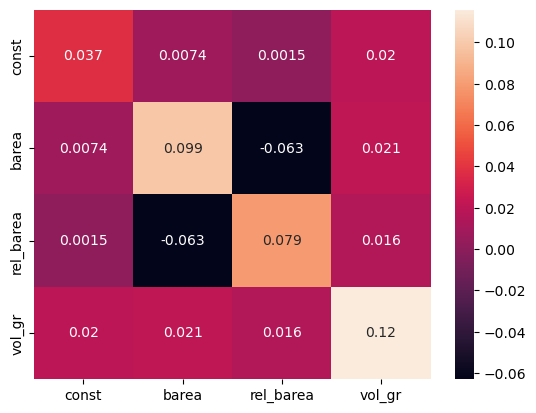

In [120]:
sb.heatmap(model.cov_params(), annot=True)

<Axes: xlabel='barea', ylabel='vol_gr'>

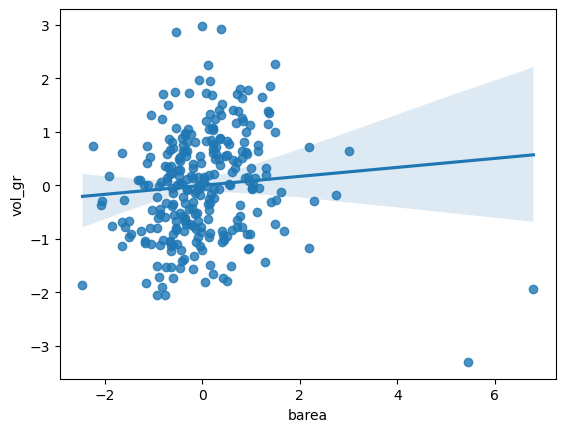

In [123]:
sb.regplot(X,x='barea',y='vol_gr')